In [38]:

import os, shutil
from glob import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt


In [75]:

in_dir = "out01_tms_induced_respose/"
in_dir2 = "data_subject_info/"

out_dir = "out02_plot_sigals/"
in_file_name = "HRF_tms_induced_response.csv"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
complete_df = pd.read_csv(in_dir + in_file_name)

subject_info = pd.read_csv(in_dir2 + "age_gender_edu.txt", sep = ',')
intensity_suds = pd.read_csv(in_dir2 + "intensity_suds.csv", sep = ',')
scalp_dist = pd.read_csv(in_dir2 + "dist_to_scalp.csv", sep = ',')
print(list(scalp_dist['site'].drop_duplicates()))


['L-FP', 'R-FP', 'L-aMFG', 'R-aMFG', 'L-pMFG', 'R-pMFG', 'R-IFJ', 'R-FEF', 'R-M1', 'R-preSMA', 'R-IPL']


In [76]:
tms_sites = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

# scalp_dist['site'] = scalp_dist['site'].str.replace('-', '_')
scalp_dist['site'].replace(list(scalp_dist['site'].drop_duplicates()), tms_sites, inplace = True)
# df['range'].str.replace(',','-')

# reformat columns in intensity_suds:
intensity_suds = pd.melt(intensity_suds, id_vars=['idall', 'MT', 'intensity'], value_vars = tms_sites,
                         var_name = 'suds_site', value_name = 'suds')

data = subject_info.merge(complete_df, left_on = 'cc_post_intake_id', right_on = 'subject')
data = data.merge(intensity_suds, how = 'left', 
                  left_on = ['cc_post_intake_id', 'site'], right_on = ['idall', 'suds_site'])

data = data.merge(scalp_dist, how = 'left', 
                  left_on = ['subject', 'site'], right_on = ['subject', 'site'])

data.drop(labels = ['inputfile', 'idall', 'cc_post_intake_id', 'suds_site'], axis = 1, inplace = True)
data.replace({'gender': {1: "male", 2: "female"}}, inplace = True)
data


,gender,age,yrs_of_edu,subject,site,group,tms_site_response_standard,tms_site_response_individual_6mm,tms_site_response_individual_10mm,tms_site_response_individual_14mm,tms_site_response_individual_14-10mm,tms_site_response_individual_10-6mm,MT,intensity,suds,scalp_dist
0,female,45,18,1001,L_Fp,NTHC,0.287125,0.439684,0.456288,0.395807,0.354767,0.462649,62.0,74.0,10.0,14.749354
1,female,45,18,1001,L_pMFG,NTHC,-0.358279,-0.463813,-0.439631,-0.329946,-0.264645,-0.431570,62.0,74.0,5.0,13.038824
2,female,45,18,1001,R_FEF,NTHC,-0.252532,-0.423779,-0.511036,-0.496599,-0.487678,-0.540984,62.0,74.0,2.0,17.079627
3,female,45,18,1001,R_Fp,NTHC,0.245202,0.278052,0.265166,0.243850,0.230372,0.260594,62.0,74.0,7.0,16.614293
4,female,45,18,1001,R_M1,NTHC,-1.002989,-1.403756,-1.606550,-1.550770,-1.520768,-1.663231,62.0,74.0,1.0,15.276347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,male,22,14,2108,R_IPL,TEHC,1.236482,0.391417,1.001566,1.383794,1.611196,1.196951,NaN,100.0,5.0,14.361543
788,male,22,14,2108,R_M1,TEHC,0.124382,0.233850,0.166974,0.150504,0.140419,0.144036,NaN,100.0,15.0,18.975313
789,male,22,14,2108,R_aMFG,TEHC,-0.279814,-0.045608,-0.032161,-0.082834,-0.115168,-0.027050,NaN,100.0,20.0,13.567683
790,male,22,14,2108,R_pMFG,TEHC,0.363362,-0.020677,0.119496,0.184963,0.224639,0.165267,NaN,100.0,20.0,14.366030


In [77]:
test_variables = ['tms_site_response_standard', 'tms_site_response_individual_6mm',
                  'tms_site_response_individual_10mm', 'tms_site_response_individual_14mm', 
                  'tms_site_response_individual_14-10mm', 'tms_site_response_individual_10-6mm']

plot_data = pd.melt(data, id_vars = ['subject', 'site', 'gender', 'suds'] + test_variables, 
                    value_vars = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist'], 
                    var_name = 'metrics', value_name='values')

plot_data.groupby('metrics')['values'].count()


metrics
MT            581
age           792
intensity     792
scalp_dist    689
yrs_of_edu    792
Name: values, dtype: int64

In [107]:
## scatter plots:
sns.set(rc={'figure.figsize':(5.2 * 11, 5.2 * 6)}, font_scale = 1.15)

from scipy.stats import pearsonr
from pingouin import partial_corr

tms_sites = data['site'].unique()
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(tms_sites)).as_hex()
colors = colors[1::2] + colors[2::2] 
scatter_para = {'alpha': 0.7, 's': 30, 'linewidth': 0.2}

def scatter_plot(plot_data, ylabel, method = 'correlation'):
    g = sns.lmplot(x = 'values', y = ylabel, hue = 'site', 
                   row = 'site', col = 'metrics', palette = colors, 
                   data = plot_data, fit_reg = True, sharex = False, sharey = True, \
                   scatter_kws=scatter_para, 
                   line_kws = {'lw': 2},
                   x_jitter = .2, order = 1,\
                   height=3.27, aspect=1, legend = False)
    
    # compute R squared for each group and cluster:
    column_title = plot_data['metrics'].unique()
    
    x_pos = [18, 12, 71, 48, 7, -5]
    x_lim = [[16, 62], [11.5, 18.5], [69, 102], [46, 85], [6, 25], [-10, 100]]
    
    for col in range(len(column_title)):
        for row in range(len(tms_sites)):
            x = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              'values'].values
            y = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              ylabel].values
                        
            if method == 'correlation':
                idx_nan = np.isnan(x) | np.isnan(y)
                r, p = pearsonr(x[~idx_nan], y[~idx_nan])
                label = "$r$ = %.3f, $p$ = %.3f" % (r, p)
                if p < .05:
                    label += '*'
            else: # partial correlation:
                z = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              'suds'].values
                
                idx_nan = np.isnan(x) | np.isnan(y) | np.isnan(z)
                df = pd.DataFrame({'x': x[~idx_nan], 'y': y[~idx_nan], 'z': z[~idx_nan]})
                res = partial_corr(df, x = 'x', y = 'y', covar = 'z')
                label = "$r$ = %.3f, $p$ = %.3f" % (res['r'], res['p-val'])
                if res['p-val'].values < .05:
                    label += '*'
            
            g.axes[row, col].set_xlim(x_lim[col])
            g.axes[row, col].text(x_pos[col], 2.5, label, fontsize = 13)
            
    return g
       

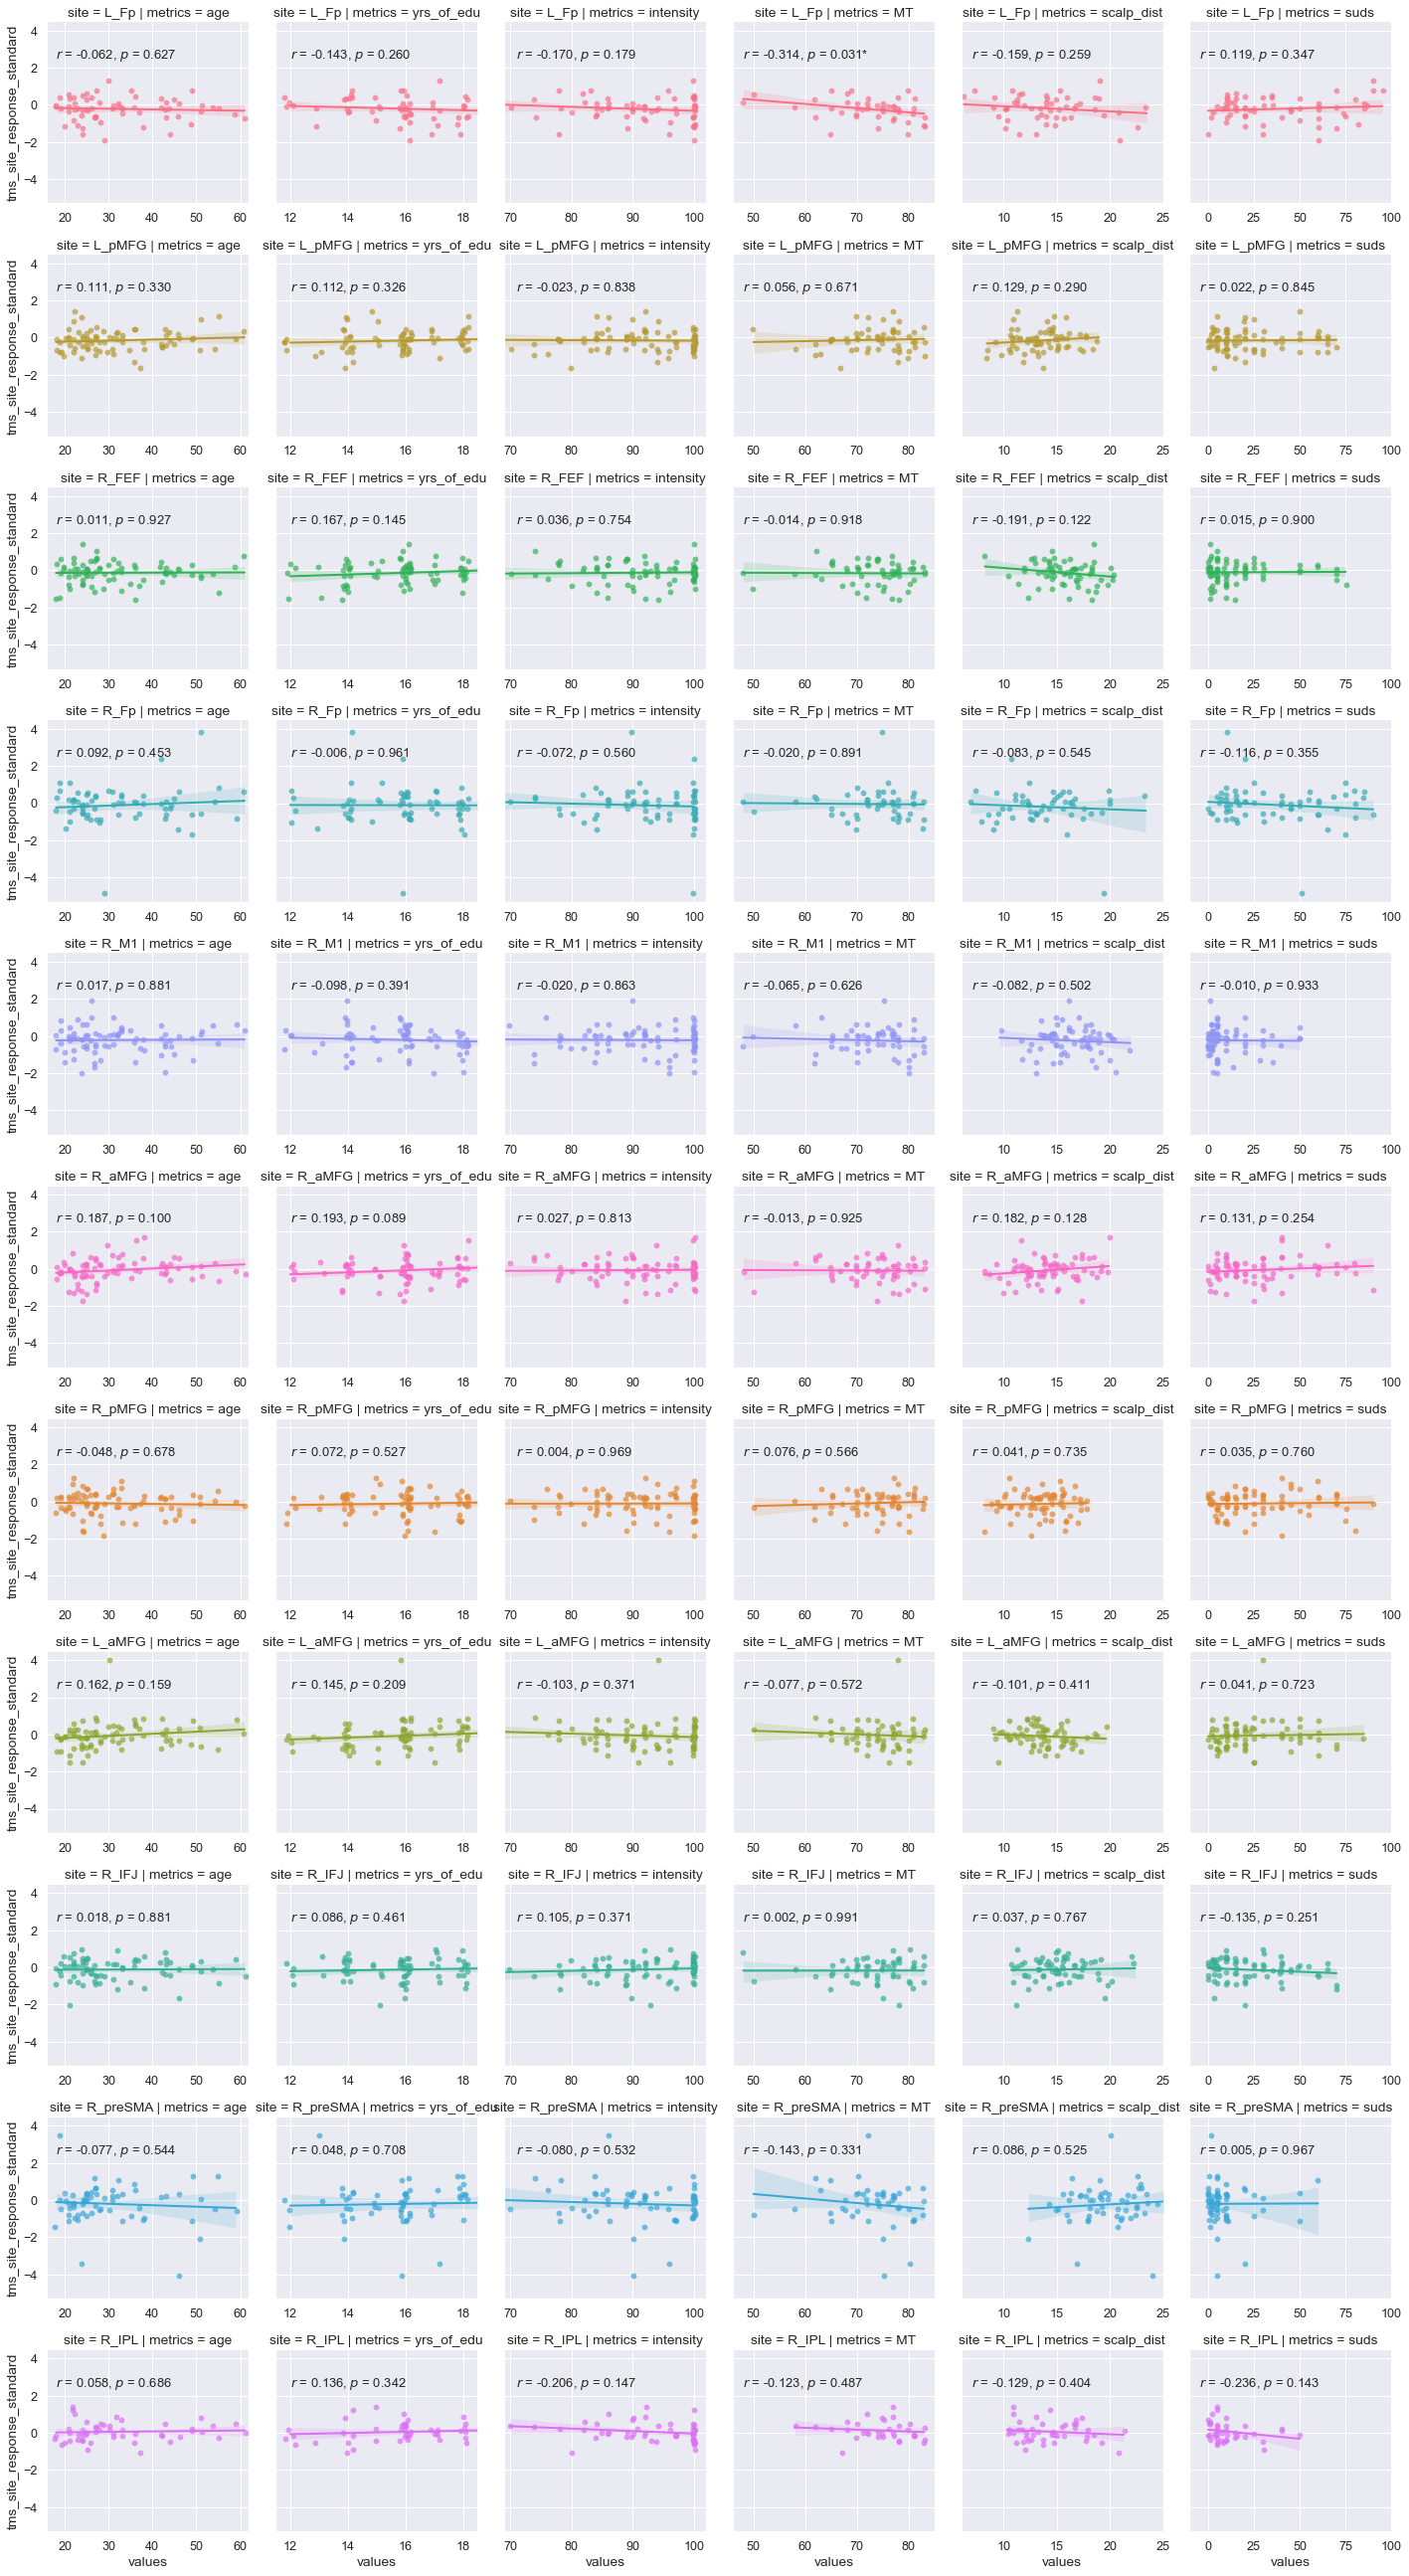

In [108]:

plot_data = pd.melt(data, id_vars = ['subject', 'site', 'gender'] + test_variables, 
                    value_vars = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist', 'suds'], 
                    var_name = 'metrics', value_name='values')

scatter_plot(plot_data, test_variables[0], 'correlation')


In [110]:
%%capture

for var in test_variables:
    f = scatter_plot(plot_data, var)
    f.savefig(out_dir+'/figure2_scatter_plots' + var + '.png', 
              dpi=600, bbox_inches = 'tight', pad_inches = 0.1)
    

In [ ]:
import statsmodels.api as sm

# backward selection

test_variables = ['tms_site_response_standard', 'tms_site_response_individual_6mm',
                  'tms_site_response_individual_10mm', 'tms_site_response_individual_14mm', 
                  'tms_site_response_individual_14-10mm', 'tms_site_response_individual_10-6mm']


data.replace({'gender': {'male': 1, 'female': 2}}, inplace = True)

roi_list = data.site.unique()

for roi in roi_list:
    print(roi)
    X = data.loc[(data['site'] == roi) & (~data['beta_value'].isna()), 
                 ['gender', 'age', 'yrs_of_edu', 'MT', 'intensity', 'suds']]
    y = data.loc[(data['site'] == roi) & (~data['beta_value'].isna()), ['beta_value']]
    
    if len(y) < 20: continue

    X = sm.add_constant(X) # adding a constant

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) 

    print_model = model.summary()
    print(print_model)